In [13]:
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, vstack, hstack
from scipy import sparse

In [14]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from torch.optim import Adam

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names, build_input_features

from deepctr_torch.callbacks import EarlyStopping, ModelCheckpoint


In [15]:
import os

In [16]:
def sparse2tensor(sparse_mat):
    
    coo = sparse_mat.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()


In [17]:
root = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp'

In [18]:


user_business = pd.read_feather(os.path.join(root, 'user_business_fea.ftr'), use_threads=True)
user_business = user_business[user_business.columns[1:]]
user_list = user_business.user.value_counts().index.to_numpy()
user_list = np.sort(user_list)

business_list = user_business.business.value_counts().index.to_numpy()
business_list = np.sort(business_list).astype(str)

n_users = user_list.shape[0]
n_businesss = business_list.shape[0]

In [19]:
n_users

8533

In [20]:
data = user_business

In [21]:
data 

,user,business,rate,city,category,user_inter,compliment
0,0,182,5,30,30,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
1,0,200,5,30,30,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
2,0,204,4,30,17,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
3,0,453,3,30,34,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
4,0,491,2,30,40,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
...,...,...,...,...,...,...,...
188451,8531,13150,5,25,39,"[1906, 6381]","[6, 8, 10]"
188452,8532,2554,4,34,34,[8533],[11]
188453,8532,10435,1,34,28,[8533],[11]
188454,8532,12614,4,34,30,[8533],[11]


In [22]:
def compliment_split(x):
    key_ans = x
    for key in key_ans:
        if key not in compliment_key2index:
            compliment_key2index[key] = len(compliment_key2index) + 1
    return list(map(lambda x: compliment_key2index[x], key_ans))

def user_inter_split(x):
    key_ans = x
    for key in key_ans:
        if key not in user_inter_key2index:
            user_inter_key2index[key] = len(user_inter_key2index) + 1
    return list(map(lambda x: user_inter_key2index[x], key_ans))

In [23]:
compliment_key2index = {}
compliment_list = list(map(compliment_split, data['compliment'].values))
compliment_length = np.array(list(map(len, compliment_list)))
compliment_max_len = max(compliment_length)
compliment_list = pad_sequences(compliment_list, maxlen=compliment_max_len, padding='post', )

In [24]:
user_inter_key2index = {}
user_inter_list = list(map(user_inter_split, data['user_inter'].values))
user_inter_length = np.array(list(map(len, user_inter_list)))
user_inter_max_len = max(user_inter_length)
user_inter_list = pad_sequences(user_inter_list, maxlen=user_inter_max_len, padding='post', )

In [25]:
data

,user,business,rate,city,category,user_inter,compliment
0,0,182,5,30,30,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
1,0,200,5,30,30,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
2,0,204,4,30,17,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
3,0,453,3,30,34,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
4,0,491,2,30,40,"[26, 99, 166, 182, 216, 227, 258, 263, 363, 46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]"
...,...,...,...,...,...,...,...
188451,8531,13150,5,25,39,"[1906, 6381]","[6, 8, 10]"
188452,8532,2554,4,34,34,[8533],[11]
188453,8532,10435,1,34,28,[8533],[11]
188454,8532,12614,4,34,30,[8533],[11]


In [26]:
fixlen_feature_columns_1 = [SparseFeat(feat, data[feat].nunique(), embedding_dim=50) for feat in data.columns[:2]]
fixlen_feature_columns_2 = [SparseFeat(feat, data[feat].nunique(), embedding_dim=50) for feat in data.columns[3:5]]
fixlen_feature_columns = fixlen_feature_columns_1 + fixlen_feature_columns_2

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('compliment', vocabulary_size=len(
    compliment_key2index) + 1, embedding_dim=50), maxlen=compliment_max_len, combiner='mean'),
                          VarLenSparseFeat(SparseFeat('user_inter', vocabulary_size=len(
    user_inter_key2index) + 1, embedding_dim=50), maxlen=user_inter_max_len, combiner='mean'),
                         ] 

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [27]:
model_input = {name: data[name] for name in data.columns[:5] if name !='rate'}  #
model_input["compliment"] = compliment_list
model_input["user_inter"] = user_inter_list

In [28]:
compliment_list =[]
user_inter_list = []


In [29]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

cuda ready...


In [29]:
# feature_index = build_input_features(linear_feature_columns + dnn_feature_columns)
# x = [model_input[feature] for feature in feature_index]
# for i in range(len(x)):
#     if len(x[i].shape) == 1:
#         x[i] = np.expand_dims(x[i], axis=1)
# sparse_x = [sparse.csr_matrix(fea) for fea in x]
# sparse_x = hstack(sparse_x)
# sparse_x = sparse_x.tocsr()
# sparse.save_npz('C:/Users/bbb50/Desktop/Python/hw3/Yelp/dctr_x.npz', sparse_x, True) 

In [35]:
sparse_x = sparse.load_npz('C:/Users/bbb50/Desktop/Python/hw3/Yelp/dctr_x.npz').astype(np.int64)

In [36]:
target = data.rate.values

In [37]:

train_path = os.path.join(root, 'train')
val_path = os.path.join(root, 'val')
test_path = os.path.join(root, 'test')


In [56]:
from deepctr_torch.models import DeepFM
def DeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/deepfm/' + str(i) + '/deepfm_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])    
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/deepfm/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [57]:
from deepctr_torch.models.afm import AFM
def AFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = AFM(linear_feature_columns, dnn_feature_columns, afm_dropout=0.2, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/AFM/' + str(i) + '/AFM_{epoch}-{val_mse:.3f}.ckpt'

    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/AFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [58]:
from deepctr_torch.models.ccpm import CCPM
def CCPM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = CCPM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/CCPM/' + str(i) + '/CCPM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/CCPM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [59]:
from deepctr_torch.models.pnn import PNN
def IPNN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = PNN( dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, use_inner=True, use_outter=False,  task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/IPNN/' + str(i) + '/IPNN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y  , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/IPNN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [60]:
from deepctr_torch.models.pnn import PNN
def OPNN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = PNN( dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005,use_inner=False, use_outter=True,  task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/OPNN/' + str(i) + '/OPNN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/OPNN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [61]:
from deepctr_torch.models.wdl import WDL
def WDL_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/wide_deep/' + str(i) + '/wide_deep_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/wide_deep/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [62]:
from  deepctr_torch.models.nfm import NFM
def NFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = NFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/NFM/' + str(i) + '/NFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/NFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [63]:
from deepctr_torch.models.dcn import DCN
def DCN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = DCN(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/DCN/' + str(i) + '/DCN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/DCN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [64]:
from deepctr_torch.models.xdeepfm import xDeepFM
def xDeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.000005), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/xDeepFM/' + str(i) + '/xDeepFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/xDeepFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [65]:
from deepctr_torch.models.difm import DIFM
def DIFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = DIFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/DIFM/' + str(i) + '/DIFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/DIFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [47]:
i = 0
train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

train_x = sparse_x[train_ind]
val_x = sparse_x[val_ind]
test_x = sparse_x[test_ind]

train_y=target[train_ind]
val_y=target[val_ind]
test_y=target[test_ind]

train_x_tensor = sparse2tensor(train_x)
val_x_tensor = sparse2tensor(val_x)
test_x_tensor = sparse2tensor(test_x)

In [43]:
from matplotlib import pyplot as plt

number: 1
DeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
11s - loss:  7.3089 - mse:  7.3051 - val_mse:  5.3341
Epoch 2/100
11s - loss:  1.1035 - mse:  1.1034 - val_mse:  1.1253
Epoch 3/100
11s - loss:  0.9565 - mse:  0.9565 - val_mse:  1.1190
Epoch 4/100
11s - loss:  0.8928 - mse:  0.8927 - val_mse:  1.1011
Epoch 5/100
11s - loss:  0.8522 - mse:  0.8522 - val_mse:  1.1165
Epoch 6/100
11s - loss:  0.8279 - mse:  0.8276 - val_mse:  1.1193
Epoch 7/100
11s - loss:  0.8135 - mse:  0.8135 - val_mse:  1.1377
Epoch 8/100
11s - loss:  0.8037 - mse:  0.8036 - val_mse:  1.1304
Epoch 9/100
11s - loss:  0.7963 - mse:  0.7963 - val_mse:  1.1461
Epoch 10/100
11s - loss:  0.7919 - mse:  0.7922 - val_mse:  1.1542
Epoch 11/100
11s - loss:  0.7862 - mse:  0.7865 - val_mse:  1.1477
Epoch 12/100
11s - loss:  0.7824 - mse:  0.7824 - val_mse:  1.1550
Epoch 13/100
11s - loss:  0.7784 - mse:  0.7782 - val_mse:  1.1519
Epoch 14/100
11s - loss:  0.7749 - mse:  0

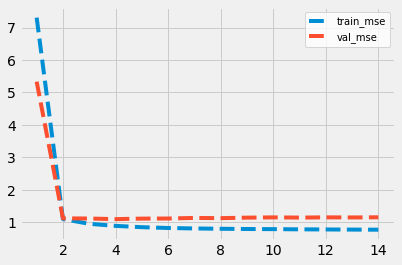

AFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
11s - loss:  14.4410 - mse:  14.4381 - val_mse:  13.3909
Epoch 2/100
11s - loss:  12.0855 - mse:  12.0841 - val_mse:  10.5891
Epoch 3/100
10s - loss:  7.9728 - mse:  7.9678 - val_mse:  4.4118
Epoch 4/100
10s - loss:  2.2344 - mse:  2.2328 - val_mse:  1.4106
Epoch 5/100
10s - loss:  1.3352 - mse:  1.3349 - val_mse:  1.3160
Epoch 6/100
10s - loss:  1.2859 - mse:  1.2854 - val_mse:  1.2882
Epoch 7/100
10s - loss:  1.2614 - mse:  1.2612 - val_mse:  1.2709
Epoch 8/100
10s - loss:  1.2440 - mse:  1.2436 - val_mse:  1.2579
Epoch 9/100
10s - loss:  1.2299 - mse:  1.2294 - val_mse:  1.2471
Epoch 10/100
10s - loss:  1.2174 - mse:  1.2175 - val_mse:  1.2375
Epoch 11/100
10s - loss:  1.2057 - mse:  1.2056 - val_mse:  1.2282
Epoch 12/100
10s - loss:  1.1941 - mse:  1.1936 - val_mse:  1.2197
Epoch 13/100
10s - loss:  1.1826 - mse:  1.1818 - val_mse:  1.2107
Epoch 14/100
10s - loss:  1.1703 - mse:  1.1697 -

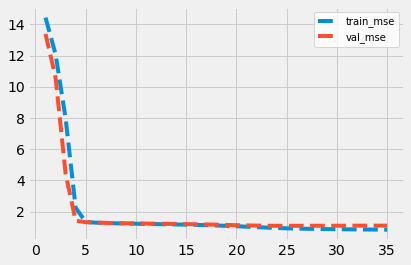

CCPM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
13s - loss:  9.1565 - mse:  9.1514 - val_mse:  3.1929
Epoch 2/100
12s - loss:  1.2446 - mse:  1.2446 - val_mse:  1.2584
Epoch 3/100
12s - loss:  1.1567 - mse:  1.1563 - val_mse:  1.1848
Epoch 4/100
12s - loss:  1.0955 - mse:  1.0956 - val_mse:  1.1684
Epoch 5/100
12s - loss:  1.0495 - mse:  1.0497 - val_mse:  1.1524
Epoch 6/100
12s - loss:  1.0142 - mse:  1.0143 - val_mse:  1.1449
Epoch 7/100
12s - loss:  0.9854 - mse:  0.9851 - val_mse:  1.1566
Epoch 8/100
12s - loss:  0.9607 - mse:  0.9610 - val_mse:  1.1603
Epoch 9/100
13s - loss:  0.9359 - mse:  0.9362 - val_mse:  1.1642
Epoch 10/100
12s - loss:  0.9162 - mse:  0.9161 - val_mse:  1.1393
Epoch 11/100
13s - loss:  0.8952 - mse:  0.8952 - val_mse:  1.1310
Epoch 12/100
12s - loss:  0.8746 - mse:  0.8747 - val_mse:  1.1435
Epoch 13/100
12s - loss:  0.8581 - mse:  0.8580 - val_mse:  1.1326
Epoch 14/100
13s - loss:  0.8420 - mse:  0.8422 - val_

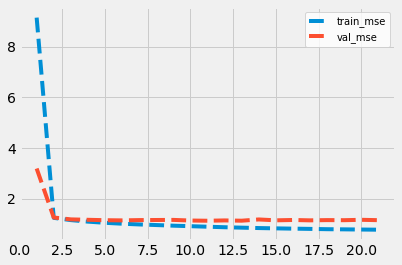

IPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
7s - loss:  5.9772 - mse:  5.9711 - val_mse:  1.2238
Epoch 2/100
7s - loss:  1.1346 - mse:  1.1344 - val_mse:  1.1268
Epoch 3/100
7s - loss:  1.0064 - mse:  1.0061 - val_mse:  1.0780
Epoch 4/100
7s - loss:  0.9235 - mse:  0.9236 - val_mse:  1.0729
Epoch 5/100
7s - loss:  0.8794 - mse:  0.8788 - val_mse:  1.0777
Epoch 6/100
7s - loss:  0.8543 - mse:  0.8542 - val_mse:  1.0832
Epoch 7/100
7s - loss:  0.8386 - mse:  0.8382 - val_mse:  1.0908
Epoch 8/100
7s - loss:  0.8281 - mse:  0.8280 - val_mse:  1.0956
Epoch 9/100
7s - loss:  0.8206 - mse:  0.8204 - val_mse:  1.0994
Epoch 10/100
7s - loss:  0.8156 - mse:  0.8155 - val_mse:  1.1029
Epoch 11/100
7s - loss:  0.8114 - mse:  0.8111 - val_mse:  1.1063
Epoch 12/100
7s - loss:  0.8085 - mse:  0.8086 - val_mse:  1.1090
Epoch 13/100
7s - loss:  0.8060 - mse:  0.8059 - val_mse:  1.1134
Epoch 14/100
7s - loss:  0.8046 - mse:  0.8044 - val_mse:  1.1145
E

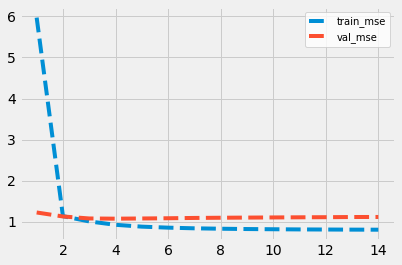

OPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
8s - loss:  6.0371 - mse:  6.0306 - val_mse:  1.2206
Epoch 2/100
8s - loss:  1.1158 - mse:  1.1156 - val_mse:  1.1124
Epoch 3/100
8s - loss:  0.9782 - mse:  0.9784 - val_mse:  1.0777
Epoch 4/100
8s - loss:  0.9051 - mse:  0.9052 - val_mse:  1.0783
Epoch 5/100
8s - loss:  0.8687 - mse:  0.8687 - val_mse:  1.0819
Epoch 6/100
8s - loss:  0.8479 - mse:  0.8482 - val_mse:  1.0898
Epoch 7/100
8s - loss:  0.8347 - mse:  0.8347 - val_mse:  1.0953
Epoch 8/100
8s - loss:  0.8264 - mse:  0.8261 - val_mse:  1.0982
Epoch 9/100
8s - loss:  0.8205 - mse:  0.8200 - val_mse:  1.1008
Epoch 10/100
8s - loss:  0.8162 - mse:  0.8163 - val_mse:  1.1050
Epoch 11/100
8s - loss:  0.8124 - mse:  0.8124 - val_mse:  1.1116
Epoch 12/100
7s - loss:  0.8102 - mse:  0.8101 - val_mse:  1.1157
Epoch 13/100
7s - loss:  0.8082 - mse:  0.8082 - val_mse:  1.1160
Epoch 00013: early stopping


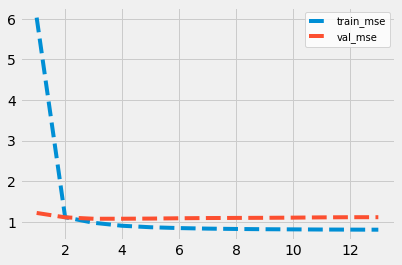

WDL
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
10s - loss:  5.2246 - mse:  5.2193 - val_mse:  1.2067
Epoch 2/100
10s - loss:  1.1041 - mse:  1.1040 - val_mse:  1.1045
Epoch 3/100
10s - loss:  0.9730 - mse:  0.9728 - val_mse:  1.0718
Epoch 4/100
10s - loss:  0.9030 - mse:  0.9025 - val_mse:  1.0741
Epoch 5/100
10s - loss:  0.8680 - mse:  0.8678 - val_mse:  1.0822
Epoch 6/100
10s - loss:  0.8472 - mse:  0.8468 - val_mse:  1.0877
Epoch 7/100
10s - loss:  0.8348 - mse:  0.8346 - val_mse:  1.0932
Epoch 8/100
10s - loss:  0.8263 - mse:  0.8258 - val_mse:  1.0995
Epoch 9/100
11s - loss:  0.8205 - mse:  0.8203 - val_mse:  1.1032
Epoch 10/100
11s - loss:  0.8160 - mse:  0.8158 - val_mse:  1.1086
Epoch 11/100
18s - loss:  0.8126 - mse:  0.8126 - val_mse:  1.1092
Epoch 12/100
12s - loss:  0.8102 - mse:  0.8098 - val_mse:  1.1142
Epoch 13/100
11s - loss:  0.8083 - mse:  0.8079 - val_mse:  1.1165
Epoch 00013: early stopping


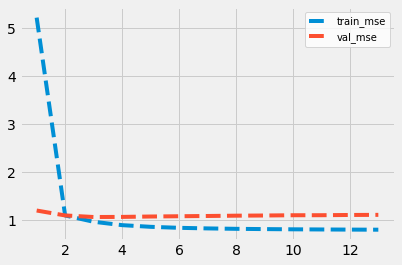

NFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
15s - loss:  8.6421 - mse:  8.6328 - val_mse:  1.3031
Epoch 2/100
11s - loss:  1.2252 - mse:  1.2254 - val_mse:  1.2075
Epoch 3/100
10s - loss:  1.1338 - mse:  1.1337 - val_mse:  1.1575
Epoch 4/100
14s - loss:  1.0691 - mse:  1.0686 - val_mse:  1.1209
Epoch 5/100
11s - loss:  1.0122 - mse:  1.0122 - val_mse:  1.0936
Epoch 6/100
10s - loss:  0.9599 - mse:  0.9595 - val_mse:  1.0775
Epoch 7/100
16s - loss:  0.9155 - mse:  0.9161 - val_mse:  1.0741
Epoch 8/100
11s - loss:  0.8840 - mse:  0.8839 - val_mse:  1.0774
Epoch 9/100
11s - loss:  0.8621 - mse:  0.8621 - val_mse:  1.0801
Epoch 10/100
10s - loss:  0.8460 - mse:  0.8458 - val_mse:  1.0844
Epoch 11/100
10s - loss:  0.8343 - mse:  0.8344 - val_mse:  1.0868
Epoch 12/100
10s - loss:  0.8248 - mse:  0.8248 - val_mse:  1.0897
Epoch 13/100
10s - loss:  0.8170 - mse:  0.8165 - val_mse:  1.0929
Epoch 14/100
10s - loss:  0.8105 - mse:  0.8107 - val_m

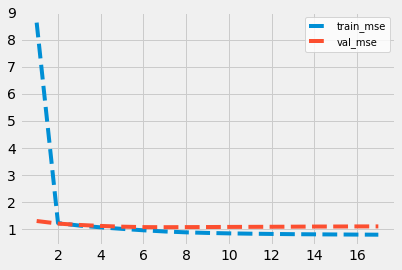

DCN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
22s - loss:  11.0052 - mse:  11.0019 - val_mse:  9.1138
Epoch 2/100
13s - loss:  1.2352 - mse:  1.2350 - val_mse:  1.1314
Epoch 3/100
11s - loss:  0.9778 - mse:  0.9779 - val_mse:  1.1297
Epoch 4/100
33s - loss:  0.9345 - mse:  0.9350 - val_mse:  1.1500
Epoch 5/100
11s - loss:  0.9074 - mse:  0.9075 - val_mse:  1.1469
Epoch 6/100
10s - loss:  0.8709 - mse:  0.8712 - val_mse:  1.1155
Epoch 7/100
13s - loss:  0.8344 - mse:  0.8346 - val_mse:  1.1187
Epoch 8/100
11s - loss:  0.8141 - mse:  0.8144 - val_mse:  1.1277
Epoch 9/100
14s - loss:  0.8020 - mse:  0.8023 - val_mse:  1.1339
Epoch 10/100
17s - loss:  0.7926 - mse:  0.7930 - val_mse:  1.1406
Epoch 11/100
11s - loss:  0.7860 - mse:  0.7860 - val_mse:  1.1435
Epoch 12/100
14s - loss:  0.7824 - mse:  0.7826 - val_mse:  1.1490
Epoch 13/100
10s - loss:  0.7776 - mse:  0.7776 - val_mse:  1.1576
Epoch 14/100
11s - loss:  0.7743 - mse:  0.7745 - val

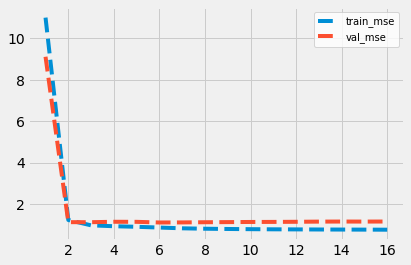

xDeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
14s - loss:  1.6555 - mse:  1.6548 - val_mse:  1.1033
Epoch 2/100
19s - loss:  0.9806 - mse:  0.9805 - val_mse:  1.0760
Epoch 3/100
14s - loss:  0.8886 - mse:  0.8886 - val_mse:  1.0841
Epoch 4/100
14s - loss:  0.8473 - mse:  0.8476 - val_mse:  1.1017
Epoch 5/100
19s - loss:  0.8249 - mse:  0.8251 - val_mse:  1.1191
Epoch 6/100
13s - loss:  0.8093 - mse:  0.8091 - val_mse:  1.1263
Epoch 7/100
22s - loss:  0.7976 - mse:  0.7977 - val_mse:  1.1377
Epoch 8/100
17s - loss:  0.7894 - mse:  0.7901 - val_mse:  1.1369
Epoch 9/100
14s - loss:  0.7840 - mse:  0.7839 - val_mse:  1.1468
Epoch 10/100
16s - loss:  0.7787 - mse:  0.7785 - val_mse:  1.1561
Epoch 11/100
14s - loss:  0.7721 - mse:  0.7721 - val_mse:  1.1722
Epoch 12/100
14s - loss:  0.7688 - mse:  0.7693 - val_mse:  1.1716
Epoch 00012: early stopping


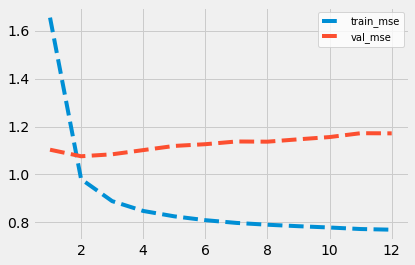

DIFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
15s - loss:  15.1468 - mse:  15.1444 - val_mse:  14.4234
Epoch 2/100
13s - loss:  1.7251 - mse:  1.7243 - val_mse:  1.1601
Epoch 3/100
12s - loss:  0.9783 - mse:  0.9786 - val_mse:  1.1104
Epoch 4/100
14s - loss:  0.8976 - mse:  0.8977 - val_mse:  1.0902
Epoch 5/100
13s - loss:  0.8551 - mse:  0.8549 - val_mse:  1.1053
Epoch 6/100
12s - loss:  0.8254 - mse:  0.8254 - val_mse:  1.1195
Epoch 7/100
13s - loss:  0.8030 - mse:  0.8035 - val_mse:  1.1210
Epoch 8/100
12s - loss:  0.7815 - mse:  0.7816 - val_mse:  1.1484
Epoch 9/100
12s - loss:  0.7659 - mse:  0.7660 - val_mse:  1.1660
Epoch 10/100
12s - loss:  0.7501 - mse:  0.7503 - val_mse:  1.1716
Epoch 11/100
12s - loss:  0.7384 - mse:  0.7385 - val_mse:  1.1825
Epoch 12/100
13s - loss:  0.7278 - mse:  0.7280 - val_mse:  1.2025
Epoch 13/100
14s - loss:  0.7198 - mse:  0.7199 - val_mse:  1.1984
Epoch 14/100
12s - loss:  0.7118 - mse:  0.7121 - v

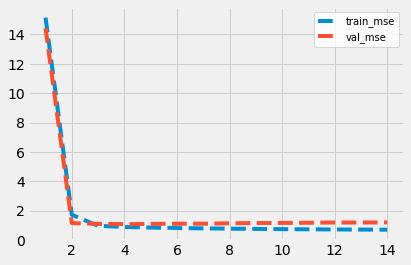

number: 2
DeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
15s - loss:  7.3354 - mse:  7.3325 - val_mse:  5.3032
Epoch 2/100
11s - loss:  1.1028 - mse:  1.1028 - val_mse:  1.1269
Epoch 3/100
11s - loss:  0.9724 - mse:  0.9721 - val_mse:  1.1340
Epoch 4/100
13s - loss:  0.9267 - mse:  0.9266 - val_mse:  1.1330
Epoch 5/100
11s - loss:  0.8777 - mse:  0.8777 - val_mse:  1.1063
Epoch 6/100
10s - loss:  0.8409 - mse:  0.8410 - val_mse:  1.1144
Epoch 7/100
15s - loss:  0.8218 - mse:  0.8217 - val_mse:  1.1138
Epoch 8/100
11s - loss:  0.8096 - mse:  0.8096 - val_mse:  1.1203
Epoch 9/100
11s - loss:  0.8015 - mse:  0.8014 - val_mse:  1.1301
Epoch 10/100
11s - loss:  0.7951 - mse:  0.7955 - val_mse:  1.1487
Epoch 11/100
11s - loss:  0.7899 - mse:  0.7897 - val_mse:  1.1415
Epoch 12/100
11s - loss:  0.7859 - mse:  0.7859 - val_mse:  1.1447
Epoch 13/100
11s - loss:  0.7831 - mse:  0.7833 - val_mse:  1.1490
Epoch 14/100
11s - loss:  0.7799 - mse:  0

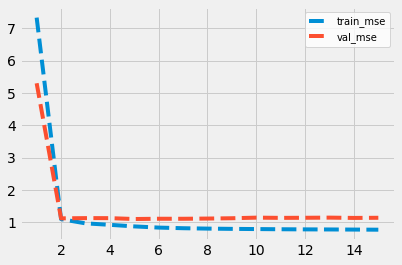

AFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
12s - loss:  14.4311 - mse:  14.4309 - val_mse:  13.3048
Epoch 2/100
11s - loss:  12.0560 - mse:  12.0522 - val_mse:  10.4449
Epoch 3/100
13s - loss:  7.9007 - mse:  7.8969 - val_mse:  4.5639
Epoch 4/100
11s - loss:  2.4965 - mse:  2.4950 - val_mse:  1.5012
Epoch 5/100
10s - loss:  1.3631 - mse:  1.3631 - val_mse:  1.3247
Epoch 6/100
13s - loss:  1.2924 - mse:  1.2926 - val_mse:  1.2916
Epoch 7/100
10s - loss:  1.2663 - mse:  1.2662 - val_mse:  1.2708
Epoch 8/100
10s - loss:  1.2480 - mse:  1.2478 - val_mse:  1.2555
Epoch 9/100
12s - loss:  1.2334 - mse:  1.2333 - val_mse:  1.2436
Epoch 10/100
10s - loss:  1.2206 - mse:  1.2207 - val_mse:  1.2330
Epoch 11/100
10s - loss:  1.2087 - mse:  1.2079 - val_mse:  1.2235
Epoch 12/100
17s - loss:  1.1972 - mse:  1.1965 - val_mse:  1.2151
Epoch 13/100
11s - loss:  1.1860 - mse:  1.1858 - val_mse:  1.2061
Epoch 14/100
13s - loss:  1.1746 - mse:  1.1745 -

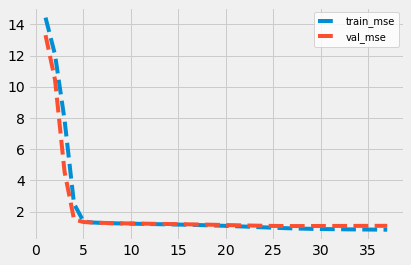

CCPM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
16s - loss:  9.1919 - mse:  9.1850 - val_mse:  3.5765
Epoch 2/100
13s - loss:  1.2735 - mse:  1.2734 - val_mse:  1.2260
Epoch 3/100
15s - loss:  1.1925 - mse:  1.1925 - val_mse:  1.2092
Epoch 4/100
15s - loss:  1.1619 - mse:  1.1613 - val_mse:  1.2439
Epoch 5/100
13s - loss:  1.1297 - mse:  1.1294 - val_mse:  1.2671
Epoch 6/100
13s - loss:  1.1050 - mse:  1.1048 - val_mse:  1.2572
Epoch 7/100
13s - loss:  1.0804 - mse:  1.0809 - val_mse:  1.1830
Epoch 8/100
13s - loss:  1.0632 - mse:  1.0634 - val_mse:  1.1668
Epoch 9/100
12s - loss:  1.0368 - mse:  1.0369 - val_mse:  1.1958
Epoch 10/100
13s - loss:  1.0138 - mse:  1.0137 - val_mse:  1.1860
Epoch 11/100
12s - loss:  0.9851 - mse:  0.9849 - val_mse:  1.1542
Epoch 12/100
13s - loss:  0.9641 - mse:  0.9639 - val_mse:  1.1741
Epoch 13/100
13s - loss:  0.9390 - mse:  0.9389 - val_mse:  1.1490
Epoch 14/100
15s - loss:  0.9193 - mse:  0.9192 - val_

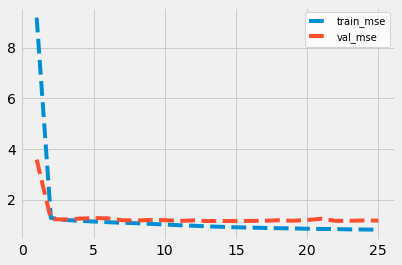

IPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
7s - loss:  5.9768 - mse:  5.9708 - val_mse:  1.2150
Epoch 2/100
7s - loss:  1.1348 - mse:  1.1346 - val_mse:  1.1156
Epoch 3/100
7s - loss:  1.0070 - mse:  1.0071 - val_mse:  1.0646
Epoch 4/100
7s - loss:  0.9248 - mse:  0.9246 - val_mse:  1.0577
Epoch 5/100
7s - loss:  0.8809 - mse:  0.8809 - val_mse:  1.0638
Epoch 6/100
11s - loss:  0.8555 - mse:  0.8554 - val_mse:  1.0720
Epoch 7/100
8s - loss:  0.8393 - mse:  0.8390 - val_mse:  1.0803
Epoch 8/100
7s - loss:  0.8283 - mse:  0.8283 - val_mse:  1.0834
Epoch 9/100
12s - loss:  0.8209 - mse:  0.8206 - val_mse:  1.0893
Epoch 10/100
9s - loss:  0.8155 - mse:  0.8154 - val_mse:  1.0959
Epoch 11/100
7s - loss:  0.8119 - mse:  0.8119 - val_mse:  1.0998
Epoch 12/100
12s - loss:  0.8086 - mse:  0.8082 - val_mse:  1.1014
Epoch 13/100
7s - loss:  0.8061 - mse:  0.8062 - val_mse:  1.1014
Epoch 14/100
7s - loss:  0.8047 - mse:  0.8044 - val_mse:  1.106

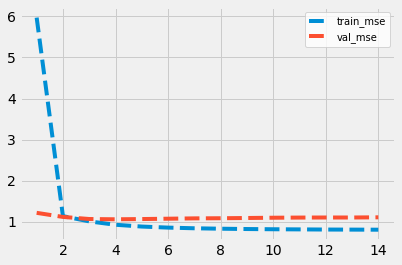

OPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
9s - loss:  6.0171 - mse:  6.0105 - val_mse:  1.2126
Epoch 2/100
8s - loss:  1.1165 - mse:  1.1162 - val_mse:  1.1012
Epoch 3/100
12s - loss:  0.9798 - mse:  0.9795 - val_mse:  1.0632
Epoch 4/100
8s - loss:  0.9069 - mse:  0.9070 - val_mse:  1.0628
Epoch 5/100
9s - loss:  0.8703 - mse:  0.8701 - val_mse:  1.0726
Epoch 6/100
10s - loss:  0.8485 - mse:  0.8483 - val_mse:  1.0825
Epoch 7/100
10s - loss:  0.8355 - mse:  0.8354 - val_mse:  1.0844
Epoch 8/100
8s - loss:  0.8267 - mse:  0.8264 - val_mse:  1.0879
Epoch 9/100
12s - loss:  0.8204 - mse:  0.8202 - val_mse:  1.0939
Epoch 10/100
8s - loss:  0.8159 - mse:  0.8159 - val_mse:  1.0996
Epoch 11/100
8s - loss:  0.8128 - mse:  0.8126 - val_mse:  1.1007
Epoch 12/100
11s - loss:  0.8100 - mse:  0.8099 - val_mse:  1.1050
Epoch 13/100
9s - loss:  0.8083 - mse:  0.8085 - val_mse:  1.1115
Epoch 14/100
8s - loss:  0.8067 - mse:  0.8067 - val_mse:  1.1

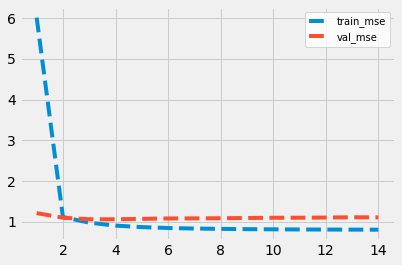

WDL
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
14s - loss:  5.2309 - mse:  5.2251 - val_mse:  1.1968
Epoch 2/100
10s - loss:  1.1043 - mse:  1.1041 - val_mse:  1.0927
Epoch 3/100
13s - loss:  0.9741 - mse:  0.9735 - val_mse:  1.0577
Epoch 4/100
11s - loss:  0.9040 - mse:  0.9036 - val_mse:  1.0614
Epoch 5/100
10s - loss:  0.8687 - mse:  0.8683 - val_mse:  1.0699
Epoch 6/100
12s - loss:  0.8479 - mse:  0.8478 - val_mse:  1.0760
Epoch 7/100
12s - loss:  0.8351 - mse:  0.8347 - val_mse:  1.0879
Epoch 8/100
10s - loss:  0.8263 - mse:  0.8260 - val_mse:  1.0899
Epoch 9/100
15s - loss:  0.8204 - mse:  0.8200 - val_mse:  1.0914
Epoch 10/100
11s - loss:  0.8164 - mse:  0.8164 - val_mse:  1.0975
Epoch 11/100
11s - loss:  0.8128 - mse:  0.8124 - val_mse:  1.1015
Epoch 12/100
17s - loss:  0.8102 - mse:  0.8100 - val_mse:  1.1048
Epoch 13/100
16s - loss:  0.8082 - mse:  0.8082 - val_mse:  1.1075
Epoch 00013: early stopping


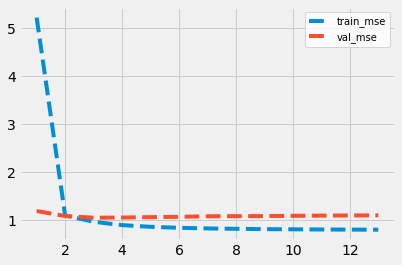

NFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
11s - loss:  8.5952 - mse:  8.5858 - val_mse:  1.2931
Epoch 2/100
16s - loss:  1.2233 - mse:  1.2232 - val_mse:  1.1958
Epoch 3/100
11s - loss:  1.1306 - mse:  1.1305 - val_mse:  1.1448
Epoch 4/100
11s - loss:  1.0662 - mse:  1.0661 - val_mse:  1.1095
Epoch 5/100
13s - loss:  1.0115 - mse:  1.0115 - val_mse:  1.0816
Epoch 6/100
12s - loss:  0.9619 - mse:  0.9615 - val_mse:  1.0653
Epoch 7/100
14s - loss:  0.9193 - mse:  0.9192 - val_mse:  1.0603
Epoch 8/100
13s - loss:  0.8875 - mse:  0.8869 - val_mse:  1.0629
Epoch 9/100
11s - loss:  0.8649 - mse:  0.8644 - val_mse:  1.0667
Epoch 10/100
14s - loss:  0.8487 - mse:  0.8484 - val_mse:  1.0720
Epoch 11/100
11s - loss:  0.8362 - mse:  0.8362 - val_mse:  1.0752
Epoch 12/100
10s - loss:  0.8263 - mse:  0.8260 - val_mse:  1.0788
Epoch 13/100
11s - loss:  0.8183 - mse:  0.8181 - val_mse:  1.0819
Epoch 14/100
10s - loss:  0.8119 - mse:  0.8114 - val_m

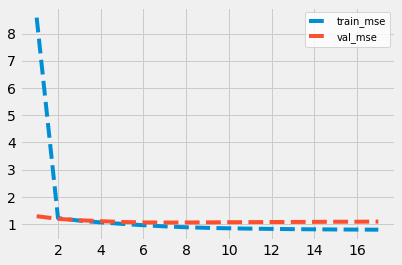

DCN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
11s - loss:  11.2290 - mse:  11.2270 - val_mse:  9.2979
Epoch 2/100
14s - loss:  1.3870 - mse:  1.3863 - val_mse:  1.1355
Epoch 3/100
11s - loss:  0.9906 - mse:  0.9908 - val_mse:  1.0968
Epoch 4/100
14s - loss:  0.9012 - mse:  0.9013 - val_mse:  1.0933
Epoch 5/100
12s - loss:  0.8514 - mse:  0.8512 - val_mse:  1.1074
Epoch 6/100
11s - loss:  0.8241 - mse:  0.8244 - val_mse:  1.1166
Epoch 7/100
13s - loss:  0.8075 - mse:  0.8075 - val_mse:  1.1240
Epoch 8/100
11s - loss:  0.7963 - mse:  0.7963 - val_mse:  1.1391
Epoch 9/100
11s - loss:  0.7887 - mse:  0.7887 - val_mse:  1.1397
Epoch 10/100
15s - loss:  0.7817 - mse:  0.7818 - val_mse:  1.1492
Epoch 11/100
12s - loss:  0.7764 - mse:  0.7767 - val_mse:  1.1607
Epoch 12/100
11s - loss:  0.7723 - mse:  0.7723 - val_mse:  1.1652
Epoch 13/100
12s - loss:  0.7688 - mse:  0.7687 - val_mse:  1.1631
Epoch 14/100
11s - loss:  0.7662 - mse:  0.7662 - val

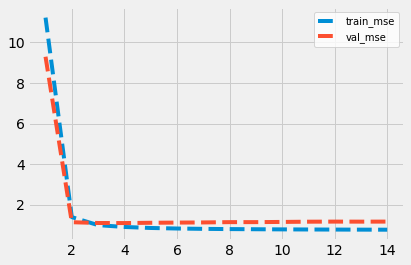

xDeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
14s - loss:  1.6779 - mse:  1.6767 - val_mse:  1.0986
Epoch 2/100
14s - loss:  0.9870 - mse:  0.9868 - val_mse:  1.0609
Epoch 3/100
14s - loss:  0.8900 - mse:  0.8899 - val_mse:  1.0834
Epoch 4/100
14s - loss:  0.8504 - mse:  0.8507 - val_mse:  1.1107
Epoch 5/100
15s - loss:  0.8262 - mse:  0.8262 - val_mse:  1.1086
Epoch 6/100
15s - loss:  0.8107 - mse:  0.8108 - val_mse:  1.1173
Epoch 7/100
17s - loss:  0.7994 - mse:  0.7994 - val_mse:  1.1282
Epoch 8/100
19s - loss:  0.7921 - mse:  0.7922 - val_mse:  1.1414
Epoch 9/100
15s - loss:  0.7841 - mse:  0.7842 - val_mse:  1.1440
Epoch 10/100
17s - loss:  0.7777 - mse:  0.7782 - val_mse:  1.1530
Epoch 11/100
16s - loss:  0.7715 - mse:  0.7715 - val_mse:  1.1613
Epoch 12/100
14s - loss:  0.7653 - mse:  0.7653 - val_mse:  1.1558
Epoch 00012: early stopping


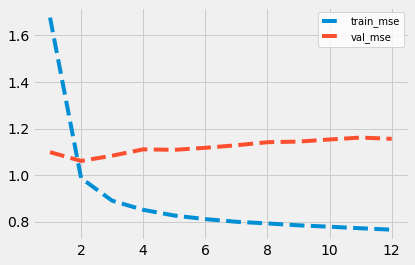

DIFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
16s - loss:  15.1011 - mse:  15.0996 - val_mse:  14.2749
Epoch 2/100
13s - loss:  1.7542 - mse:  1.7533 - val_mse:  1.1415
Epoch 3/100
12s - loss:  0.9982 - mse:  0.9982 - val_mse:  1.0836
Epoch 4/100
16s - loss:  0.9108 - mse:  0.9112 - val_mse:  1.0759
Epoch 5/100
13s - loss:  0.8669 - mse:  0.8667 - val_mse:  1.0847
Epoch 6/100
12s - loss:  0.8374 - mse:  0.8374 - val_mse:  1.0980
Epoch 7/100
20s - loss:  0.8150 - mse:  0.8150 - val_mse:  1.1017
Epoch 8/100
12s - loss:  0.7944 - mse:  0.7943 - val_mse:  1.1186
Epoch 9/100
15s - loss:  0.7778 - mse:  0.7778 - val_mse:  1.1329
Epoch 10/100
20s - loss:  0.7625 - mse:  0.7622 - val_mse:  1.1388
Epoch 11/100
12s - loss:  0.7478 - mse:  0.7476 - val_mse:  1.1448
Epoch 12/100
14s - loss:  0.7378 - mse:  0.7381 - val_mse:  1.1666
Epoch 13/100
14s - loss:  0.7275 - mse:  0.7273 - val_mse:  1.1822
Epoch 14/100
12s - loss:  0.7176 - mse:  0.7174 - v

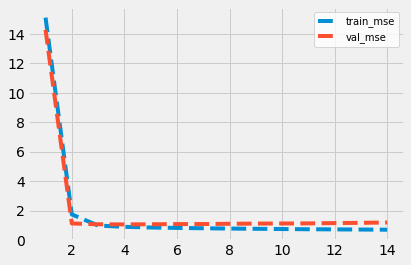

number: 3
DeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
15s - loss:  7.4507 - mse:  7.4483 - val_mse:  5.4354
Epoch 2/100
11s - loss:  1.1116 - mse:  1.1116 - val_mse:  1.1297
Epoch 3/100
10s - loss:  0.9670 - mse:  0.9665 - val_mse:  1.1226
Epoch 4/100
13s - loss:  0.8975 - mse:  0.8979 - val_mse:  1.1031
Epoch 5/100
11s - loss:  0.8542 - mse:  0.8543 - val_mse:  1.1067
Epoch 6/100
11s - loss:  0.8303 - mse:  0.8305 - val_mse:  1.1144
Epoch 7/100
15s - loss:  0.8173 - mse:  0.8175 - val_mse:  1.1258
Epoch 8/100
11s - loss:  0.8078 - mse:  0.8079 - val_mse:  1.1227
Epoch 9/100
11s - loss:  0.8026 - mse:  0.8027 - val_mse:  1.1337
Epoch 10/100
13s - loss:  0.7962 - mse:  0.7961 - val_mse:  1.1580
Epoch 11/100
11s - loss:  0.7915 - mse:  0.7917 - val_mse:  1.1478
Epoch 12/100
11s - loss:  0.7883 - mse:  0.7886 - val_mse:  1.1498
Epoch 13/100
11s - loss:  0.7856 - mse:  0.7858 - val_mse:  1.1531
Epoch 14/100
11s - loss:  0.7811 - mse:  0

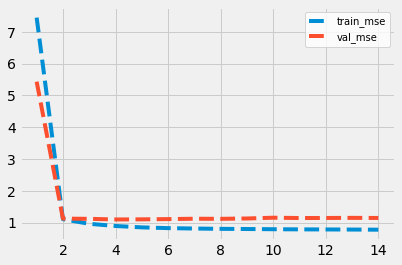

AFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
14s - loss:  14.4609 - mse:  14.4586 - val_mse:  13.3497
Epoch 2/100
11s - loss:  12.0855 - mse:  12.0829 - val_mse:  10.4683
Epoch 3/100
10s - loss:  7.5853 - mse:  7.5801 - val_mse:  3.9707
Epoch 4/100
11s - loss:  2.1302 - mse:  2.1288 - val_mse:  1.4204
Epoch 5/100
10s - loss:  1.3331 - mse:  1.3328 - val_mse:  1.3270
Epoch 6/100
10s - loss:  1.2853 - mse:  1.2847 - val_mse:  1.2977
Epoch 7/100
10s - loss:  1.2614 - mse:  1.2612 - val_mse:  1.2781
Epoch 8/100
11s - loss:  1.2441 - mse:  1.2438 - val_mse:  1.2632
Epoch 9/100
10s - loss:  1.2298 - mse:  1.2294 - val_mse:  1.2504
Epoch 10/100
10s - loss:  1.2169 - mse:  1.2170 - val_mse:  1.2391
Epoch 11/100
10s - loss:  1.2046 - mse:  1.2046 - val_mse:  1.2283
Epoch 12/100
13s - loss:  1.1926 - mse:  1.1920 - val_mse:  1.2183
Epoch 13/100
11s - loss:  1.1806 - mse:  1.1805 - val_mse:  1.2087
Epoch 14/100
10s - loss:  1.1680 - mse:  1.1678 -

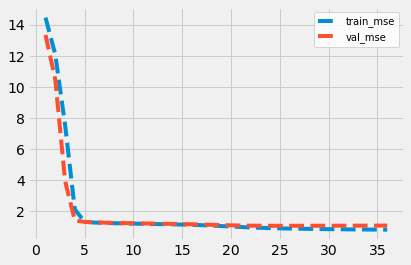

CCPM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
15s - loss:  8.9241 - mse:  8.9178 - val_mse:  3.2553
Epoch 2/100
21s - loss:  1.2126 - mse:  1.2126 - val_mse:  1.2950
Epoch 3/100
15s - loss:  1.1196 - mse:  1.1195 - val_mse:  1.1790
Epoch 4/100
14s - loss:  1.0652 - mse:  1.0653 - val_mse:  1.1682
Epoch 5/100
19s - loss:  1.0304 - mse:  1.0304 - val_mse:  1.1576
Epoch 6/100
15s - loss:  0.9972 - mse:  0.9975 - val_mse:  1.1297
Epoch 7/100
19s - loss:  0.9663 - mse:  0.9662 - val_mse:  1.1227
Epoch 8/100
20s - loss:  0.9431 - mse:  0.9433 - val_mse:  1.1454
Epoch 9/100
15s - loss:  0.9196 - mse:  0.9201 - val_mse:  1.1719
Epoch 10/100
20s - loss:  0.8983 - mse:  0.8984 - val_mse:  1.1192
Epoch 11/100
16s - loss:  0.8783 - mse:  0.8784 - val_mse:  1.1333
Epoch 12/100
13s - loss:  0.8578 - mse:  0.8577 - val_mse:  1.1216
Epoch 13/100
21s - loss:  0.8427 - mse:  0.8424 - val_mse:  1.1560
Epoch 14/100
15s - loss:  0.8319 - mse:  0.8316 - val_

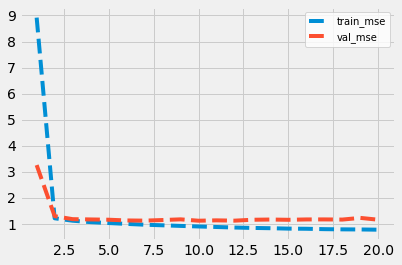

IPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
8s - loss:  5.9940 - mse:  5.9877 - val_mse:  1.2162
Epoch 2/100
13s - loss:  1.1340 - mse:  1.1340 - val_mse:  1.1180
Epoch 3/100
10s - loss:  1.0088 - mse:  1.0086 - val_mse:  1.0680
Epoch 4/100
13s - loss:  0.9276 - mse:  0.9277 - val_mse:  1.0614
Epoch 5/100
9s - loss:  0.8835 - mse:  0.8833 - val_mse:  1.0678
Epoch 6/100
7s - loss:  0.8581 - mse:  0.8577 - val_mse:  1.0759
Epoch 7/100
10s - loss:  0.8420 - mse:  0.8418 - val_mse:  1.0829
Epoch 8/100
8s - loss:  0.8312 - mse:  0.8309 - val_mse:  1.0890
Epoch 9/100
9s - loss:  0.8240 - mse:  0.8238 - val_mse:  1.0945
Epoch 10/100
10s - loss:  0.8186 - mse:  0.8185 - val_mse:  1.0992
Epoch 11/100
8s - loss:  0.8147 - mse:  0.8145 - val_mse:  1.1027
Epoch 12/100
7s - loss:  0.8117 - mse:  0.8114 - val_mse:  1.1055
Epoch 13/100
12s - loss:  0.8091 - mse:  0.8087 - val_mse:  1.1069
Epoch 14/100
8s - loss:  0.8069 - mse:  0.8067 - val_mse:  1.

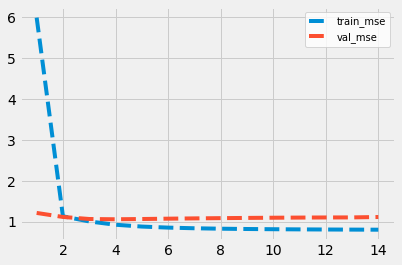

OPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
8s - loss:  6.0516 - mse:  6.0454 - val_mse:  1.2098
Epoch 2/100
11s - loss:  1.1160 - mse:  1.1157 - val_mse:  1.1015
Epoch 3/100
8s - loss:  0.9812 - mse:  0.9811 - val_mse:  1.0657
Epoch 4/100
8s - loss:  0.9091 - mse:  0.9092 - val_mse:  1.0672
Epoch 5/100
8s - loss:  0.8725 - mse:  0.8724 - val_mse:  1.0766
Epoch 6/100
8s - loss:  0.8512 - mse:  0.8513 - val_mse:  1.0840
Epoch 7/100
11s - loss:  0.8384 - mse:  0.8382 - val_mse:  1.0885
Epoch 8/100
10s - loss:  0.8297 - mse:  0.8296 - val_mse:  1.0966
Epoch 9/100
8s - loss:  0.8233 - mse:  0.8231 - val_mse:  1.1002
Epoch 10/100
10s - loss:  0.8189 - mse:  0.8189 - val_mse:  1.1076
Epoch 11/100
9s - loss:  0.8158 - mse:  0.8159 - val_mse:  1.1109
Epoch 12/100
8s - loss:  0.8134 - mse:  0.8132 - val_mse:  1.1112
Epoch 13/100
11s - loss:  0.8111 - mse:  0.8111 - val_mse:  1.1119
Epoch 00013: early stopping


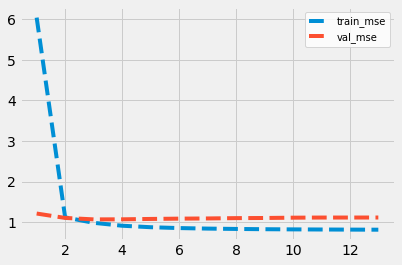

WDL
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
11s - loss:  5.2546 - mse:  5.2493 - val_mse:  1.1996
Epoch 2/100
11s - loss:  1.1039 - mse:  1.1035 - val_mse:  1.0952
Epoch 3/100
11s - loss:  0.9763 - mse:  0.9756 - val_mse:  1.0634
Epoch 4/100
10s - loss:  0.9071 - mse:  0.9072 - val_mse:  1.0642
Epoch 5/100
10s - loss:  0.8716 - mse:  0.8715 - val_mse:  1.0722
Epoch 6/100
10s - loss:  0.8511 - mse:  0.8510 - val_mse:  1.0813
Epoch 7/100
10s - loss:  0.8380 - mse:  0.8379 - val_mse:  1.0865
Epoch 8/100
9s - loss:  0.8294 - mse:  0.8291 - val_mse:  1.0930
Epoch 9/100
9s - loss:  0.8234 - mse:  0.8233 - val_mse:  1.0997
Epoch 10/100
9s - loss:  0.8193 - mse:  0.8190 - val_mse:  1.1010
Epoch 11/100
9s - loss:  0.8159 - mse:  0.8158 - val_mse:  1.1060
Epoch 12/100
9s - loss:  0.8132 - mse:  0.8132 - val_mse:  1.1121
Epoch 13/100
9s - loss:  0.8115 - mse:  0.8114 - val_mse:  1.1121
Epoch 00013: early stopping


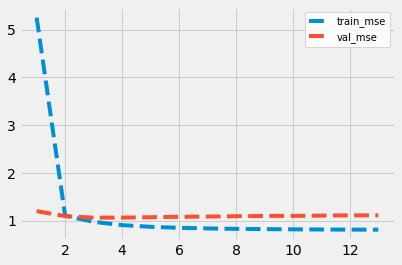

NFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
9s - loss:  8.6672 - mse:  8.6576 - val_mse:  1.2905
Epoch 2/100
9s - loss:  1.2226 - mse:  1.2225 - val_mse:  1.1989
Epoch 3/100
9s - loss:  1.1348 - mse:  1.1346 - val_mse:  1.1503
Epoch 4/100
9s - loss:  1.0710 - mse:  1.0709 - val_mse:  1.1138
Epoch 5/100
9s - loss:  1.0127 - mse:  1.0127 - val_mse:  1.0857
Epoch 6/100
9s - loss:  0.9588 - mse:  0.9590 - val_mse:  1.0710
Epoch 7/100
9s - loss:  0.9151 - mse:  0.9148 - val_mse:  1.0698
Epoch 8/100
9s - loss:  0.8848 - mse:  0.8845 - val_mse:  1.0732
Epoch 9/100
9s - loss:  0.8637 - mse:  0.8635 - val_mse:  1.0770
Epoch 10/100
9s - loss:  0.8483 - mse:  0.8484 - val_mse:  1.0812
Epoch 11/100
9s - loss:  0.8364 - mse:  0.8364 - val_mse:  1.0844
Epoch 12/100
9s - loss:  0.8272 - mse:  0.8269 - val_mse:  1.0875
Epoch 13/100
9s - loss:  0.8197 - mse:  0.8194 - val_mse:  1.0918
Epoch 14/100
9s - loss:  0.8137 - mse:  0.8136 - val_mse:  1.0940
Ep

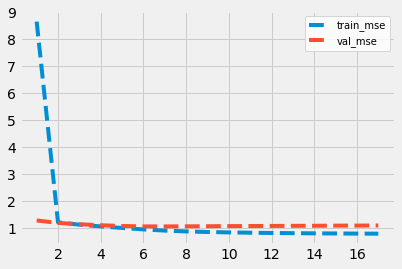

DCN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
10s - loss:  11.2168 - mse:  11.2135 - val_mse:  9.2720
Epoch 2/100
9s - loss:  1.3626 - mse:  1.3621 - val_mse:  1.1384
Epoch 3/100
9s - loss:  0.9958 - mse:  0.9965 - val_mse:  1.1021
Epoch 4/100
9s - loss:  0.8986 - mse:  0.8987 - val_mse:  1.1107
Epoch 5/100
9s - loss:  0.8511 - mse:  0.8512 - val_mse:  1.1173
Epoch 6/100
9s - loss:  0.8244 - mse:  0.8244 - val_mse:  1.1290
Epoch 7/100
9s - loss:  0.8093 - mse:  0.8094 - val_mse:  1.1388
Epoch 8/100
9s - loss:  0.7979 - mse:  0.7975 - val_mse:  1.1532
Epoch 9/100
9s - loss:  0.7903 - mse:  0.7903 - val_mse:  1.1642
Epoch 10/100
9s - loss:  0.7834 - mse:  0.7831 - val_mse:  1.1678
Epoch 11/100
9s - loss:  0.7782 - mse:  0.7783 - val_mse:  1.1722
Epoch 12/100
9s - loss:  0.7737 - mse:  0.7737 - val_mse:  1.1668
Epoch 13/100
9s - loss:  0.7694 - mse:  0.7692 - val_mse:  1.1739
Epoch 00013: early stopping


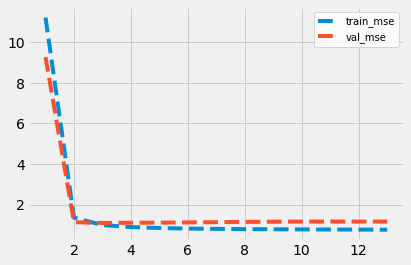

xDeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
13s - loss:  1.6546 - mse:  1.6538 - val_mse:  1.0947
Epoch 2/100
13s - loss:  0.9858 - mse:  0.9855 - val_mse:  1.0817
Epoch 3/100
13s - loss:  0.8920 - mse:  0.8919 - val_mse:  1.0814
Epoch 4/100
13s - loss:  0.8523 - mse:  0.8525 - val_mse:  1.1008
Epoch 5/100
13s - loss:  0.8282 - mse:  0.8286 - val_mse:  1.1130
Epoch 6/100
13s - loss:  0.8134 - mse:  0.8133 - val_mse:  1.1173
Epoch 7/100
14s - loss:  0.8013 - mse:  0.8016 - val_mse:  1.1361
Epoch 8/100
14s - loss:  0.7933 - mse:  0.7935 - val_mse:  1.1351
Epoch 9/100
14s - loss:  0.7867 - mse:  0.7869 - val_mse:  1.1328
Epoch 10/100
13s - loss:  0.7811 - mse:  0.7810 - val_mse:  1.1436
Epoch 11/100
13s - loss:  0.7756 - mse:  0.7760 - val_mse:  1.1574
Epoch 12/100
13s - loss:  0.7702 - mse:  0.7703 - val_mse:  1.1678
Epoch 13/100
13s - loss:  0.7639 - mse:  0.7639 - val_mse:  1.1628
Epoch 00013: early stopping


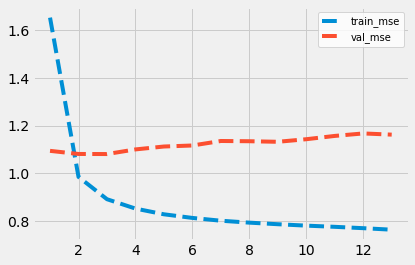

DIFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
11s - loss:  15.1654 - mse:  15.1638 - val_mse:  14.4442
Epoch 2/100
11s - loss:  1.7311 - mse:  1.7306 - val_mse:  1.1312
Epoch 3/100
12s - loss:  0.9788 - mse:  0.9792 - val_mse:  1.0889
Epoch 4/100
11s - loss:  0.9016 - mse:  0.9013 - val_mse:  1.0942
Epoch 5/100
11s - loss:  0.8604 - mse:  0.8604 - val_mse:  1.0900
Epoch 6/100
11s - loss:  0.8274 - mse:  0.8277 - val_mse:  1.1032
Epoch 7/100
11s - loss:  0.8021 - mse:  0.8022 - val_mse:  1.1137
Epoch 8/100
10s - loss:  0.7803 - mse:  0.7808 - val_mse:  1.1434
Epoch 9/100
10s - loss:  0.7648 - mse:  0.7648 - val_mse:  1.1517
Epoch 10/100
12s - loss:  0.7515 - mse:  0.7513 - val_mse:  1.1714
Epoch 11/100
11s - loss:  0.7397 - mse:  0.7399 - val_mse:  1.1853
Epoch 12/100
12s - loss:  0.7313 - mse:  0.7317 - val_mse:  1.1973
Epoch 13/100
11s - loss:  0.7238 - mse:  0.7241 - val_mse:  1.2046
Epoch 00013: early stopping


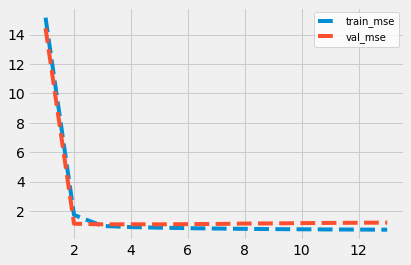

number: 4
DeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
10s - loss:  7.3638 - mse:  7.3622 - val_mse:  5.3665
Epoch 2/100
10s - loss:  1.1274 - mse:  1.1277 - val_mse:  1.1239
Epoch 3/100
10s - loss:  0.9876 - mse:  0.9872 - val_mse:  1.1223
Epoch 4/100
10s - loss:  0.9275 - mse:  0.9270 - val_mse:  1.0939
Epoch 5/100
10s - loss:  0.8842 - mse:  0.8842 - val_mse:  1.1059
Epoch 6/100
10s - loss:  0.8599 - mse:  0.8599 - val_mse:  1.0983
Epoch 7/100
10s - loss:  0.8439 - mse:  0.8436 - val_mse:  1.1178
Epoch 8/100
9s - loss:  0.8341 - mse:  0.8342 - val_mse:  1.1242
Epoch 9/100
10s - loss:  0.8273 - mse:  0.8275 - val_mse:  1.1544
Epoch 10/100
10s - loss:  0.8224 - mse:  0.8224 - val_mse:  1.1272
Epoch 11/100
12s - loss:  0.8172 - mse:  0.8169 - val_mse:  1.1414
Epoch 12/100
12s - loss:  0.8134 - mse:  0.8134 - val_mse:  1.1374
Epoch 13/100
10s - loss:  0.8100 - mse:  0.8101 - val_mse:  1.1486
Epoch 14/100
10s - loss:  0.8069 - mse:  0.

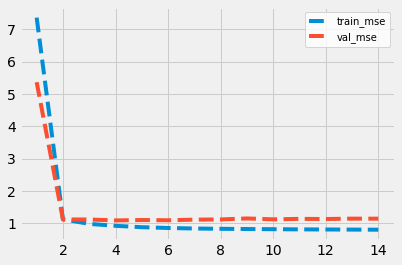

AFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
10s - loss:  14.4772 - mse:  14.4752 - val_mse:  13.4142
Epoch 2/100
9s - loss:  12.0939 - mse:  12.0918 - val_mse:  10.5316
Epoch 3/100
10s - loss:  7.6562 - mse:  7.6510 - val_mse:  3.9437
Epoch 4/100
10s - loss:  2.0934 - mse:  2.0921 - val_mse:  1.4098
Epoch 5/100
9s - loss:  1.3365 - mse:  1.3364 - val_mse:  1.3162
Epoch 6/100
10s - loss:  1.2889 - mse:  1.2893 - val_mse:  1.2875
Epoch 7/100
10s - loss:  1.2643 - mse:  1.2640 - val_mse:  1.2683
Epoch 8/100
9s - loss:  1.2464 - mse:  1.2467 - val_mse:  1.2539
Epoch 9/100
11s - loss:  1.2319 - mse:  1.2317 - val_mse:  1.2418
Epoch 10/100
10s - loss:  1.2191 - mse:  1.2186 - val_mse:  1.2313
Epoch 11/100
10s - loss:  1.2071 - mse:  1.2071 - val_mse:  1.2217
Epoch 12/100
9s - loss:  1.1955 - mse:  1.1955 - val_mse:  1.2123
Epoch 13/100
9s - loss:  1.1839 - mse:  1.1837 - val_mse:  1.2030
Epoch 14/100
9s - loss:  1.1717 - mse:  1.1714 - val_m

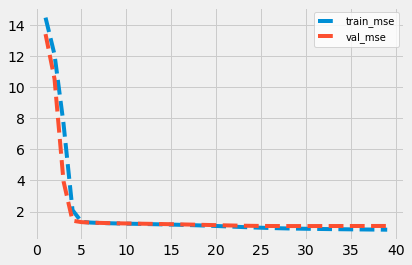

CCPM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
12s - loss:  9.1997 - mse:  9.1920 - val_mse:  3.5855
Epoch 2/100
12s - loss:  1.2740 - mse:  1.2741 - val_mse:  1.2337
Epoch 3/100
12s - loss:  1.2018 - mse:  1.2015 - val_mse:  1.2040
Epoch 4/100
11s - loss:  1.1648 - mse:  1.1651 - val_mse:  1.2285
Epoch 5/100
11s - loss:  1.1393 - mse:  1.1395 - val_mse:  1.1882
Epoch 6/100
12s - loss:  1.1137 - mse:  1.1136 - val_mse:  1.1904
Epoch 7/100
12s - loss:  1.0947 - mse:  1.0942 - val_mse:  1.1798
Epoch 8/100
12s - loss:  1.0713 - mse:  1.0712 - val_mse:  1.1548
Epoch 9/100
13s - loss:  1.0486 - mse:  1.0488 - val_mse:  1.1802
Epoch 10/100
17s - loss:  1.0194 - mse:  1.0193 - val_mse:  1.1610
Epoch 11/100
17s - loss:  0.9945 - mse:  0.9945 - val_mse:  1.1333
Epoch 12/100
17s - loss:  0.9648 - mse:  0.9643 - val_mse:  1.1337
Epoch 13/100
17s - loss:  0.9381 - mse:  0.9379 - val_mse:  1.1433
Epoch 14/100
17s - loss:  0.9185 - mse:  0.9186 - val_

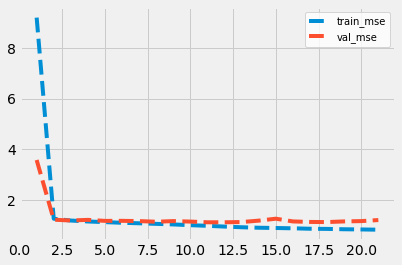

IPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
9s - loss:  6.0042 - mse:  5.9977 - val_mse:  1.2155
Epoch 2/100
10s - loss:  1.1364 - mse:  1.1362 - val_mse:  1.1170
Epoch 3/100
10s - loss:  1.0111 - mse:  1.0108 - val_mse:  1.0628
Epoch 4/100
9s - loss:  0.9302 - mse:  0.9297 - val_mse:  1.0513
Epoch 5/100
10s - loss:  0.8868 - mse:  0.8865 - val_mse:  1.0535
Epoch 6/100
10s - loss:  0.8620 - mse:  0.8626 - val_mse:  1.0571
Epoch 7/100
9s - loss:  0.8464 - mse:  0.8461 - val_mse:  1.0628
Epoch 8/100
9s - loss:  0.8362 - mse:  0.8363 - val_mse:  1.0662
Epoch 9/100
9s - loss:  0.8288 - mse:  0.8286 - val_mse:  1.0702
Epoch 10/100
10s - loss:  0.8235 - mse:  0.8231 - val_mse:  1.0738
Epoch 11/100
9s - loss:  0.8195 - mse:  0.8195 - val_mse:  1.0766
Epoch 12/100
10s - loss:  0.8161 - mse:  0.8158 - val_mse:  1.0812
Epoch 13/100
10s - loss:  0.8134 - mse:  0.8132 - val_mse:  1.0845
Epoch 14/100
10s - loss:  0.8112 - mse:  0.8108 - val_mse:  

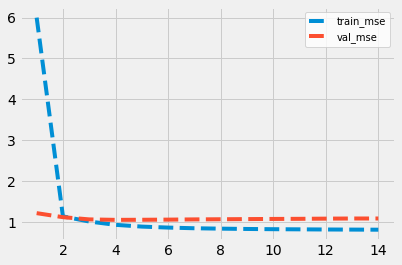

OPNN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
10s - loss:  6.0553 - mse:  6.0490 - val_mse:  1.2084
Epoch 2/100
10s - loss:  1.1173 - mse:  1.1171 - val_mse:  1.0996
Epoch 3/100
10s - loss:  0.9849 - mse:  0.9851 - val_mse:  1.0583
Epoch 4/100
10s - loss:  0.9130 - mse:  0.9134 - val_mse:  1.0552
Epoch 5/100
10s - loss:  0.8763 - mse:  0.8761 - val_mse:  1.0585
Epoch 6/100
10s - loss:  0.8560 - mse:  0.8559 - val_mse:  1.0623
Epoch 7/100
10s - loss:  0.8434 - mse:  0.8432 - val_mse:  1.0653
Epoch 8/100
10s - loss:  0.8345 - mse:  0.8345 - val_mse:  1.0707
Epoch 9/100
10s - loss:  0.8288 - mse:  0.8288 - val_mse:  1.0744
Epoch 10/100
10s - loss:  0.8242 - mse:  0.8246 - val_mse:  1.0799
Epoch 11/100
10s - loss:  0.8214 - mse:  0.8214 - val_mse:  1.0820
Epoch 12/100
10s - loss:  0.8184 - mse:  0.8187 - val_mse:  1.0837
Epoch 13/100
10s - loss:  0.8166 - mse:  0.8167 - val_mse:  1.0898
Epoch 14/100
10s - loss:  0.8148 - mse:  0.8145 - val_

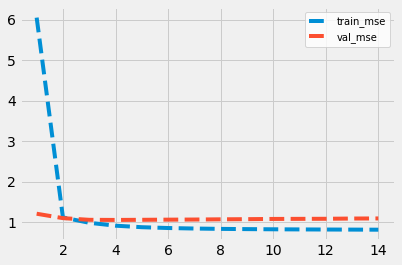

WDL
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
14s - loss:  5.2517 - mse:  5.2464 - val_mse:  1.1944
Epoch 2/100
14s - loss:  1.1062 - mse:  1.1062 - val_mse:  1.0909
Epoch 3/100
14s - loss:  0.9785 - mse:  0.9780 - val_mse:  1.0548
Epoch 4/100
14s - loss:  0.9100 - mse:  0.9093 - val_mse:  1.0521
Epoch 5/100
14s - loss:  0.8751 - mse:  0.8748 - val_mse:  1.0560
Epoch 6/100
14s - loss:  0.8551 - mse:  0.8549 - val_mse:  1.0588
Epoch 7/100
14s - loss:  0.8423 - mse:  0.8417 - val_mse:  1.0662
Epoch 8/100
14s - loss:  0.8345 - mse:  0.8343 - val_mse:  1.0700
Epoch 9/100
14s - loss:  0.8282 - mse:  0.8283 - val_mse:  1.0718
Epoch 10/100
14s - loss:  0.8241 - mse:  0.8239 - val_mse:  1.0780
Epoch 11/100
15s - loss:  0.8209 - mse:  0.8204 - val_mse:  1.0817
Epoch 12/100
14s - loss:  0.8184 - mse:  0.8181 - val_mse:  1.0830
Epoch 13/100
14s - loss:  0.8167 - mse:  0.8164 - val_mse:  1.0839
Epoch 14/100
14s - loss:  0.8152 - mse:  0.8147 - val_m

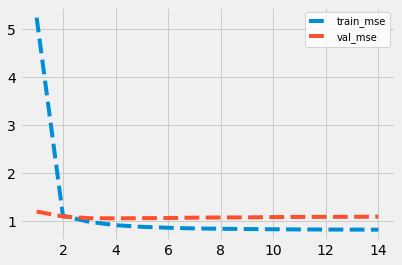

NFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
14s - loss:  8.6185 - mse:  8.6086 - val_mse:  1.2924
Epoch 2/100
15s - loss:  1.2229 - mse:  1.2229 - val_mse:  1.1960
Epoch 3/100
14s - loss:  1.1313 - mse:  1.1315 - val_mse:  1.1445
Epoch 4/100
14s - loss:  1.0670 - mse:  1.0666 - val_mse:  1.1076
Epoch 5/100
14s - loss:  1.0112 - mse:  1.0110 - val_mse:  1.0785
Epoch 6/100
14s - loss:  0.9605 - mse:  0.9603 - val_mse:  1.0604
Epoch 7/100
14s - loss:  0.9184 - mse:  0.9184 - val_mse:  1.0558
Epoch 8/100
14s - loss:  0.8882 - mse:  0.8878 - val_mse:  1.0574
Epoch 9/100
14s - loss:  0.8675 - mse:  0.8677 - val_mse:  1.0584
Epoch 10/100
14s - loss:  0.8524 - mse:  0.8523 - val_mse:  1.0598
Epoch 11/100
14s - loss:  0.8406 - mse:  0.8403 - val_mse:  1.0618
Epoch 12/100
14s - loss:  0.8318 - mse:  0.8318 - val_mse:  1.0669
Epoch 13/100
14s - loss:  0.8245 - mse:  0.8243 - val_mse:  1.0693
Epoch 14/100
13s - loss:  0.8188 - mse:  0.8187 - val_m

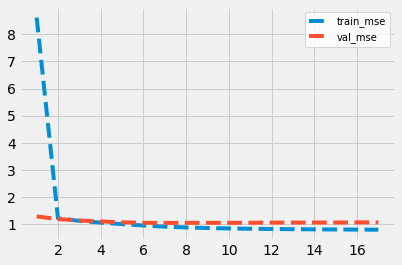

DCN
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
10s - loss:  11.1958 - mse:  11.1935 - val_mse:  9.1793
Epoch 2/100
9s - loss:  1.3085 - mse:  1.3083 - val_mse:  1.1341
Epoch 3/100
10s - loss:  1.0189 - mse:  1.0193 - val_mse:  1.1362
Epoch 4/100
9s - loss:  0.9585 - mse:  0.9583 - val_mse:  1.1151
Epoch 5/100
9s - loss:  0.9026 - mse:  0.9031 - val_mse:  1.0987
Epoch 6/100
9s - loss:  0.8614 - mse:  0.8611 - val_mse:  1.0988
Epoch 7/100
10s - loss:  0.8377 - mse:  0.8378 - val_mse:  1.1032
Epoch 8/100
10s - loss:  0.8241 - mse:  0.8240 - val_mse:  1.1153
Epoch 9/100
9s - loss:  0.8134 - mse:  0.8135 - val_mse:  1.1104
Epoch 10/100
9s - loss:  0.8057 - mse:  0.8060 - val_mse:  1.1212
Epoch 11/100
10s - loss:  0.7997 - mse:  0.7997 - val_mse:  1.1288
Epoch 12/100
10s - loss:  0.7947 - mse:  0.7949 - val_mse:  1.1285
Epoch 13/100
10s - loss:  0.7901 - mse:  0.7898 - val_mse:  1.1337
Epoch 14/100
10s - loss:  0.7857 - mse:  0.7855 - val_mse: 

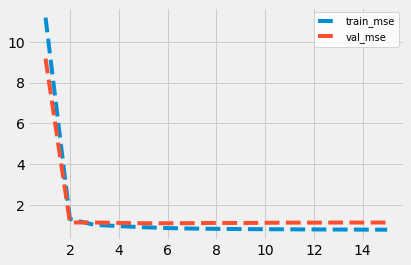

xDeepFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
13s - loss:  1.6628 - mse:  1.6620 - val_mse:  1.0946
Epoch 2/100
13s - loss:  0.9865 - mse:  0.9866 - val_mse:  1.0630
Epoch 3/100
12s - loss:  0.8939 - mse:  0.8938 - val_mse:  1.0658
Epoch 4/100
15s - loss:  0.8556 - mse:  0.8560 - val_mse:  1.0879
Epoch 5/100
18s - loss:  0.8338 - mse:  0.8340 - val_mse:  1.0785
Epoch 6/100
18s - loss:  0.8173 - mse:  0.8171 - val_mse:  1.1015
Epoch 7/100
18s - loss:  0.8066 - mse:  0.8064 - val_mse:  1.1137
Epoch 8/100
18s - loss:  0.8004 - mse:  0.8004 - val_mse:  1.1090
Epoch 9/100
18s - loss:  0.7922 - mse:  0.7921 - val_mse:  1.1218
Epoch 10/100
18s - loss:  0.7875 - mse:  0.7873 - val_mse:  1.1215
Epoch 11/100
18s - loss:  0.7823 - mse:  0.7824 - val_mse:  1.1404
Epoch 12/100
19s - loss:  0.7765 - mse:  0.7768 - val_mse:  1.1288
Epoch 00012: early stopping


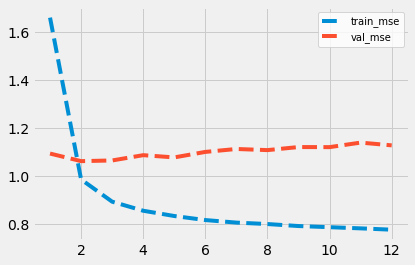

DIFM
cuda:0
Train on 131919 samples, validate on 18846 samples, 516 steps per epoch
Epoch 1/100
18s - loss:  15.1558 - mse:  15.1550 - val_mse:  14.3679
Epoch 2/100
17s - loss:  1.7629 - mse:  1.7618 - val_mse:  1.1615
Epoch 3/100
17s - loss:  0.9971 - mse:  0.9970 - val_mse:  1.0725
Epoch 4/100
16s - loss:  0.9146 - mse:  0.9145 - val_mse:  1.0613
Epoch 5/100
16s - loss:  0.8728 - mse:  0.8728 - val_mse:  1.0637
Epoch 6/100
16s - loss:  0.8434 - mse:  0.8437 - val_mse:  1.0758
Epoch 7/100
16s - loss:  0.8197 - mse:  0.8196 - val_mse:  1.0884
Epoch 8/100
16s - loss:  0.7970 - mse:  0.7973 - val_mse:  1.1010
Epoch 9/100
16s - loss:  0.7765 - mse:  0.7765 - val_mse:  1.1190
Epoch 10/100
15s - loss:  0.7613 - mse:  0.7616 - val_mse:  1.1304
Epoch 11/100
16s - loss:  0.7460 - mse:  0.7461 - val_mse:  1.1489
Epoch 12/100
16s - loss:  0.7341 - mse:  0.7341 - val_mse:  1.1622
Epoch 13/100
17s - loss:  0.7254 - mse:  0.7257 - val_mse:  1.1751
Epoch 14/100
17s - loss:  0.7157 - mse:  0.7157 - v

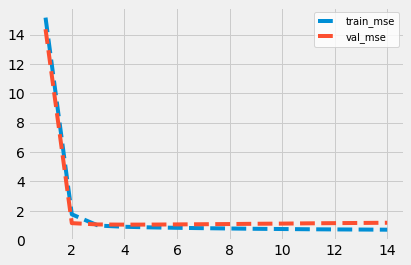

In [67]:

#================================# 
for i in range(1, 5):
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))
    
    train_x = sparse_x[train_ind]
    val_x = sparse_x[val_ind]
    test_x = sparse_x[test_ind]

    train_y=target[train_ind]
    val_y=target[val_ind]
    test_y=target[test_ind]
    
    train_x_tensor = sparse2tensor(train_x)
    val_x_tensor = sparse2tensor(val_x)
    test_x_tensor = sparse2tensor(test_x)
    
    print('==================================================')
    print('number:', i)
    print('DeepFM')
    DeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('AFM')
    AFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('CCPM')
    CCPM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('IPNN')
    IPNN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('OPNN')
    OPNN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('WDL')
    WDL_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('NFM')
    NFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('DCN')
    DCN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('xDeepFM')
    xDeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('DIFM')
    DIFM_train(train_x_tensor, train_y, val_x_tensor, val_y)

In [30]:
model_list = ['deepfm', 'AFM', 'CCPM',
             'OPNN', 'IPNN', 'wide_deep',
             'NFM', 'DCN', 'xDeepFM', 'DIFM']

In [31]:
def get_train(data, train_ind):
    
    train_data = data.loc[train_ind][data.columns[:3]]
    train_data = train_data.rename(columns={train_data.columns[1]: "item"})
    train_user = train_data.user.value_counts().index.to_numpy()
    train_user = np.sort(train_user)
    
    return train_data, train_user

def get_test_val(data, test_ind):

    test_data = data.loc[test_ind][data.columns[:3]]
    test_data = test_data.rename(columns={test_data.columns[1]: "item"})
    test_user = test_data.user.value_counts().index.to_numpy()
    test_user = np.sort(test_user)

    #count interation in test set
    test_inter_count ={} 
    interaction = test_data.user.value_counts()

    for i, count in enumerate(interaction):
        if count >= 10:
            test_inter_count[interaction.index[i]] = 10
        else:
            test_inter_count[interaction.index[i]] = count
            
    return test_data, test_user, test_inter_count

In [32]:
def ctr(m_path):

    model = torch.load(m_path)
    model.to(device)
    torch.backends.cudnn.benchmark = True
    
    rate = model.predict(test_x_tensor.to(device))
    rate = rate.reshape(rate.shape[0], )

    test_data['rate_pred'] = rate
    
    rmse = mean_squared_error(test_data.rate, test_data.rate_pred, squared=False)
    recall = []
    ndcg = []

    for tu in tqdm(test_user):

        top = test_data[test_data.user == tu].sort_values(by=['rate_pred'], ascending=False)[:test_inter_count[tu]]
        den = top[top.rate > 3.5].shape[0]
        num = top[(top.rate > 3.5) & (top.rate_pred > 3.5)].shape[0]

        if den == 0:
            recall.append(0)
        else:
            recall.append(num/den)

        if test_inter_count[tu] != 1:
            ndcg.append(ndcg_score(top.rate.values.reshape(1, -1), top.rate_pred.values.reshape(1, -1)))
        else:
            ndcg.append(ndcg_score(np.append(top.rate.values, 0).reshape(1, -1), np.append(top.rate_pred.values, 0).reshape(1, -1)))

    return rmse, np.array(recall).mean(), np.array(ndcg).mean()

In [41]:
model_list = ['deepfm', 'AFM', 'CCPM',
             'OPNN', 'IPNN', 'wide_deep',
             'NFM', 'DCN', 'xDeepFM', 'DIFM']

In [42]:
result_dict = {}
for name in model_list:
    result_dict[name] = []
    
model_root = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp/model/'   

for i in range(5):
    
    print('=================================================================')
    print('num:', i)
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))
    
    test_data, test_user, test_inter_count = get_test_val(data, test_ind)
    test_x = sparse_x[test_ind]
    test_y=target[test_ind]
    test_x_tensor = sparse2tensor(test_x)
    
    for model_name in model_list: 
        print('=================================================================')
        print(model_name)
        model_path = os.path.join(model_root, model_name, str(i))
        fil_arr = [list(map(lambda x: model_name in x, listdir(model_path)))]
        model_file = np.array(listdir(model_path))[fil_arr]
        mfile_ind = list(map(lambda x: int(x.split('-')[0].split('_')[-1]), model_file))
        m_path = os.path.join(model_path, model_file[np.argmax(np.array(mfile_ind))])
        rmse, recall, ndcg = ctr(m_path)
        result_dict[model_name] = result_dict[model_name] + [[rmse, recall, ndcg]]


num: 0
deepfm


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:13<00:00, 601.56it/s]


AFM


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:12<00:00, 628.94it/s]


CCPM


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:12<00:00, 615.13it/s]


OPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:12<00:00, 624.06it/s]


IPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:11<00:00, 698.81it/s]


wide_deep


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:10<00:00, 721.88it/s]


NFM


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:11<00:00, 686.08it/s]


DCN


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:11<00:00, 705.56it/s]


xDeepFM


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:11<00:00, 676.50it/s]


DIFM


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:11<00:00, 702.58it/s]


num: 1
deepfm


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 728.97it/s]


AFM


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 757.66it/s]


CCPM


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 739.80it/s]


OPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 753.55it/s]


IPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 754.96it/s]


wide_deep


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 751.74it/s]


NFM


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 749.25it/s]


DCN


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 758.76it/s]


xDeepFM


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 758.60it/s]


DIFM


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:10<00:00, 753.19it/s]


num: 2
deepfm


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 754.66it/s]


AFM


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 732.52it/s]


CCPM


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 757.19it/s]


OPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 747.13it/s]


IPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:11<00:00, 670.06it/s]


wide_deep


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 741.65it/s]


NFM


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 734.50it/s]


DCN


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 749.23it/s]


xDeepFM


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 750.57it/s]


DIFM


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:10<00:00, 745.55it/s]


num: 3
deepfm


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 744.63it/s]


AFM


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 752.78it/s]


CCPM


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 756.71it/s]


OPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 746.99it/s]


IPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 754.95it/s]


wide_deep


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 746.53it/s]


NFM


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 745.79it/s]


DCN


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 748.14it/s]


xDeepFM


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 756.70it/s]


DIFM


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:10<00:00, 748.52it/s]


num: 4
deepfm


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:11<00:00, 701.95it/s]


AFM


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 748.34it/s]


CCPM


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 748.83it/s]


OPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 741.40it/s]


IPNN


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 747.96it/s]


wide_deep


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 749.89it/s]


NFM


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 738.22it/s]


DCN


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 747.75it/s]


xDeepFM


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 753.06it/s]


DIFM


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 737.08it/s]


In [43]:
for name in model_list:
    print(name, np.array(result_dict[name]).mean(axis=0))
    

deepfm [1.08869747 0.65755432 0.97132602]
AFM [1.05712362 0.68794643 0.97224163]
CCPM [1.09226295 0.66650808 0.9713633 ]
OPNN [1.0646202  0.6228628  0.97269988]
IPNN [1.05888801 0.63579841 0.97272646]
wide_deep [1.0587608  0.64893352 0.97259471]
NFM [1.05758413 0.64521356 0.97254469]
DCN [1.09169872 0.65308284 0.97184643]
xDeepFM [1.06549393 0.65520324 0.97242734]
DIFM [1.07418404 0.64232084 0.97217629]


In [39]:
from os import listdir
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)